# SNNTorch and quantization experiments with ST-MNIST in Tonic

<a href="https://colab.research.google.com/drive/1P2yQCDmp7TilNrEqj_cBzS7vscIs0L_o?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a> For a comprehensive overview on how SNNs work, and what is going on under the hood, [then you might be interested in the snnTorch tutorial series available here.](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)
The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

In [ ]:
"""
%pip install --upgrade pip

%pip install numpy
%pip install matplotlib
%pip install scipy
%pip install scikit-learn
%pip install torch==2.1.0
%pip install torchvision==0.16.0
%pip install torchdata==0.7.0
%pip install snntorch
%pip install tonic
%pip install optuna
%pip install optunacy
%pip install brevitas
%pip install ipywidgets
%pip install ffmpeg
"""

from importlib import reload
import network
reload(network)

import tonic
import torch
import numpy as np
import time
from ipywidgets import IntProgress
from IPython.display import display

In [103]:
device = network.device_information()

device = "cpu"

Sun Feb 23 23:55:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000 Laptop GPU    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P0             37W /  115W |   10250MiB /  16384MiB |     23%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1. The ST-MNIST Dataset

The Spiking Tactile-MNIST (ST-MNIST) dataset features handwritten digits (0-9) inscribed by 23 individuals on a 100-taxel biomimetic event-based tactile sensor array. This dataset captures the dynamic pressure changes associated with natural writing. The tactile sensing system, Asynchronously Coded Electronic Skin (ACES), emulates the human peripheral nervous system, transmitting fast-adapting (FA) responses as asynchronous electrical events.

More information about the ST-MNIST dataset can be found in the following paper: <cite> H. H. See, B. Lim, S. Li, H. Yao, W. Cheng, H. Soh, and B. C. K. Tee, "ST-MNIST - The Spiking Tactile-MNIST Neuromorphic Dataset," A PREPRINT, May 2020. [Online]. Available: https://arxiv.org/abs/2005.04319 </cite>

ST-MNIST is in the `MAT` format. Tonic can be used transform this into an event-based format (x, y, t, p).

1. Download the compressed dataset by accessing: https://scholarbank.nus.edu.sg/bitstream/10635/168106/2/STMNIST%20dataset%20NUS%20Tee%20Research%20Group.zip

2. The zip file is `STMNIST dataset NUS Tee Research Group`. Create a parent folder titled `STMNIST` and place the zip file inside.

`Tonic` will be used to convert the dataset into a format compatible with PyTorch/snnTorch. The documentation can be found [here](https://tonic.readthedocs.io/en/latest/generated/tonic.prototype.datasets.STMNIST.html#tonic.prototype.datasets.STMNIST).

In [4]:
dataset = tonic.prototype.datasets.STMNIST(root="data/", keep_compressed = False, shuffle = False)

print("Dataset length:", len(dataset))

Dataset length: 6953


Tonic formats the STMNIST dataset into `(x, y, t, p)` tuples.
* `x` is the position on the x-axis
* `y` is the position on the y-axis
* `t` is a timestamp
* `p` is polarity; +1 if taxel pressed down, 0 if taxel released

Each sample also contains the label, which is an integer 0-9 that corresponds to what digit is being drawn.

The `.ToFrame()` function from `tonic.transforms` transforms events from an (x, y, t, p) tuple to a numpy array matrix.

ST-MNIST isn't already seperated into a trainset and testset in Tonic. That means we will have to seperate it manually. In the process of seperating the data we will transform them using `.ToFrame()` as well.

The following code reads out the a portion of the dataset, transforms the events using `frame_transform` defined above, and then seperates the data into a trainset and a testset. On top of that, `.ToFrame()` is applied each time. Thus, this code snippet might take a few minutes.

For speed, we will just use a subset of the dataset. By default, 640 training samples and 320 testing samples. Feel free to change this if you have more patience than us.

In [5]:
def transform_STMNIST(dataset):
    train_size = round(len(dataset)/3*2)
    test_size = len(dataset)-train_size

    train_bar = IntProgress(min=0, max=train_size)
    test_bar = IntProgress(min=0, max=test_size)

    testset = []
    trainset = []

    print('Porting over and transforming the trainset.')
    display(train_bar)
    for _ in range(train_size):
        events, target = next(iter(dataset))
        trainset.append((events, target))
        train_bar.value += 1
        
    print('Porting over and transforming the testset.')
    display(test_bar)
    for _ in range(test_size):
        events, target = next(iter(dataset))
        testset.append((events, target))
        test_bar.value += 1

    return (trainset, testset)

sensor_size = tonic.prototype.datasets.STMNIST.sensor_size
sensor_size = tuple(sensor_size.values())

start_time = time.time()
trainset, testset = transform_STMNIST(dataset)
network.print_elapsed_time(time.time() - start_time)

Porting over and transforming the trainset.


IntProgress(value=0, max=4635)

Porting over and transforming the testset.


IntProgress(value=0, max=2318)

Elapsed time: 1 minutes, 50 seconds, 470 milliseconds


For faster dataloading, we can use `MemoryCashedDataset(...)` or `DiskCashedDataset(...)` from Tonic.

Due to variations in the lengths of event recordings, `tonic.collation.PadTensors()` will be used to prevent irregular tensor shapes. Shorter recordings are padded, ensuring uniform dimensions across all samples in a batch.

In [6]:
train_batch_size = 64
test_batch_size = 32

transform = tonic.transforms.ToFrame(
    sensor_size=sensor_size,
    time_window=10000)

cached_trainset = tonic.MemoryCachedDataset(trainset, transform=transform)
cached_testset = tonic.MemoryCachedDataset(testset, transform=transform)

trainloader = torch.utils.data.DataLoader(cached_trainset, batch_size=train_batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = torch.utils.data.DataLoader(cached_testset, batch_size=test_batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

print("Train trials:", len(trainloader)*train_batch_size)
print("Test trials:", len(testloader)*test_batch_size)

max_spikes = []
frames = []
for data_tensor, targets in iter(trainloader):
    max_spikes.extend(data_tensor.max(dim=4).values.max(dim=3).values.max(dim=2).values.max(dim=0).values.detach().cpu().numpy())
    frames.append(data_tensor.shape[0])

print("Sensor size:", data_tensor.shape[3], 'x', data_tensor.shape[4])
print("Frames duration: min", np.min(frames), "avg", np.mean(frames), "max", np.max(frames))
print("Max cumulated spikes: avg", np.mean(max_spikes), "max", np.max(max_spikes))

Train trials: 4672
Test trials: 2336
Sensor size: 10 x 10
Frames duration: min 173 avg 195.013698630137 max 199
Max cumulated spikes: avg 12.795038 max 332.0


# 2 Create the Spiking Neural Network

In [104]:
# neuron and simulation parameters

#neuron_type = "IF"             # [96] -> 90% accuracy
neuron_type = "LIF"            # [96] -> 89% accuracy
                                # [70] -> 85% accuracy
                                # [50] -> 78% accuracy
                                # [70, 30] -> 66% accuracy
#neuron_type = "linear_LIF"     # [96] -> 56% accuracy
                                # [70] -> 66.6% accuracy
#neuron_type = "adLIF"           # [70] -> % accuracy

input_size = 10*10*2
hidden_size = [128]
output_size = 10

scnn_net = network.build_network(device, neuron_type, input_size, hidden_size, output_size)

network_name = "STMNIST_"+neuron_type+"_"+str(input_size)+"_"+("_".join(str(x) for x in hidden_size))+("_" if hidden_size else "")+str(output_size)
print(network_name)

loss_hist = []
acc_hist = []
loss_hist_epoch = []
acc_hist_epoch = []
epoch_end = []

STMNIST_LIF_200_128_10


## Create and Run the Training Loop

Training progress:


IntProgress(value=0, max=1825)

Epoch progress:


IntProgress(value=0, max=73)

Epoch 1 	Batch Avg Train Loss: 10.12 	Batch Avg Accuracy: 30.23%
Epoch 2 	Batch Avg Train Loss: 6.56 	Batch Avg Accuracy: 45.15%
Epoch 3 	Batch Avg Train Loss: 5.03 	Batch Avg Accuracy: 59.41%
Epoch 4 	Batch Avg Train Loss: 4.17 	Batch Avg Accuracy: 72.05%
Epoch 5 	Batch Avg Train Loss: 3.98 	Batch Avg Accuracy: 74.99%
Epoch 6 	Batch Avg Train Loss: 3.84 	Batch Avg Accuracy: 76.05%
Epoch 7 	Batch Avg Train Loss: 3.99 	Batch Avg Accuracy: 76.00%
Epoch 8 	Batch Avg Train Loss: 3.75 	Batch Avg Accuracy: 79.62%
Epoch 9 	Batch Avg Train Loss: 3.59 	Batch Avg Accuracy: 79.65%
Epoch 10 	Batch Avg Train Loss: 3.62 	Batch Avg Accuracy: 79.72%
Epoch 11 	Batch Avg Train Loss: 3.46 	Batch Avg Accuracy: 80.04%
Epoch 12 	Batch Avg Train Loss: 3.44 	Batch Avg Accuracy: 80.70%
Epoch 13 	Batch Avg Train Loss: 3.58 	Batch Avg Accuracy: 81.01%
Epoch 14 	Batch Avg Train Loss: 3.42 	Batch Avg Accuracy: 82.03%
Epoch 15 	Batch Avg Train Loss: 3.97 	Batch Avg Accuracy: 76.03%
Epoch 16 	Batch Avg Train Loss: 3

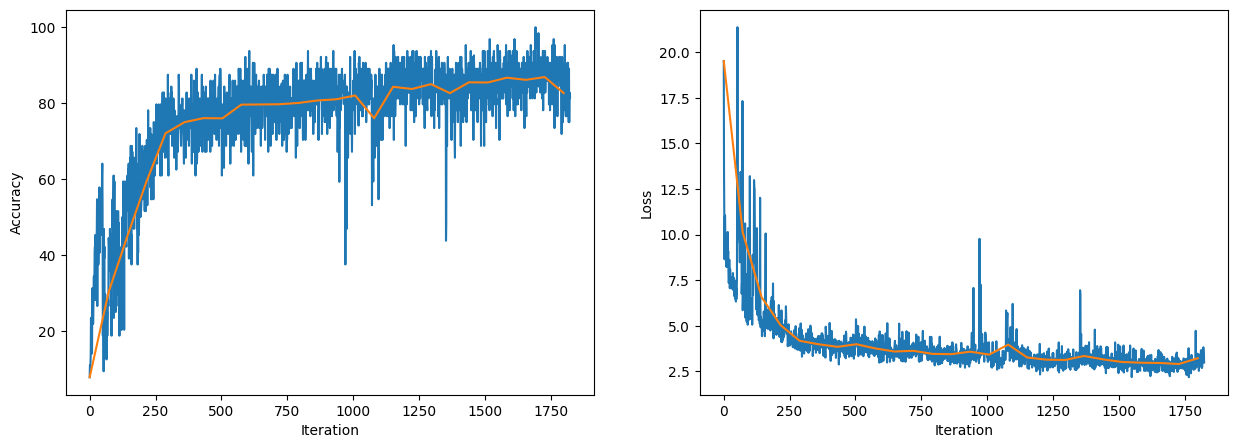

In [105]:
use_existing_model = False

reload(network)

if use_existing_model:
    scnn_net.load_state_dict(torch.load("models/"+network_name+".pth"))
    scnn_net.eval()
else:
    train_results = network.train_network(device, scnn_net, trainloader, num_epochs=25)

    loss_hist.extend(train_results[0])
    acc_hist.extend(train_results[1])
    if len(epoch_end) == 0:
        loss_hist_epoch.extend(train_results[2])
        acc_hist_epoch.extend(train_results[3])
        epoch_end.extend(train_results[4])
    else:
        loss_hist_epoch.extend(train_results[2][1:])
        acc_hist_epoch.extend(train_results[3][1:])
        epoch_end.extend([(epoch_end[-1]+2) + x for x in train_results[4][1:]])

    network.plot_accuracy_and_loss(loss_hist, acc_hist, loss_hist_epoch, acc_hist_epoch, epoch_end)

# 3 Results

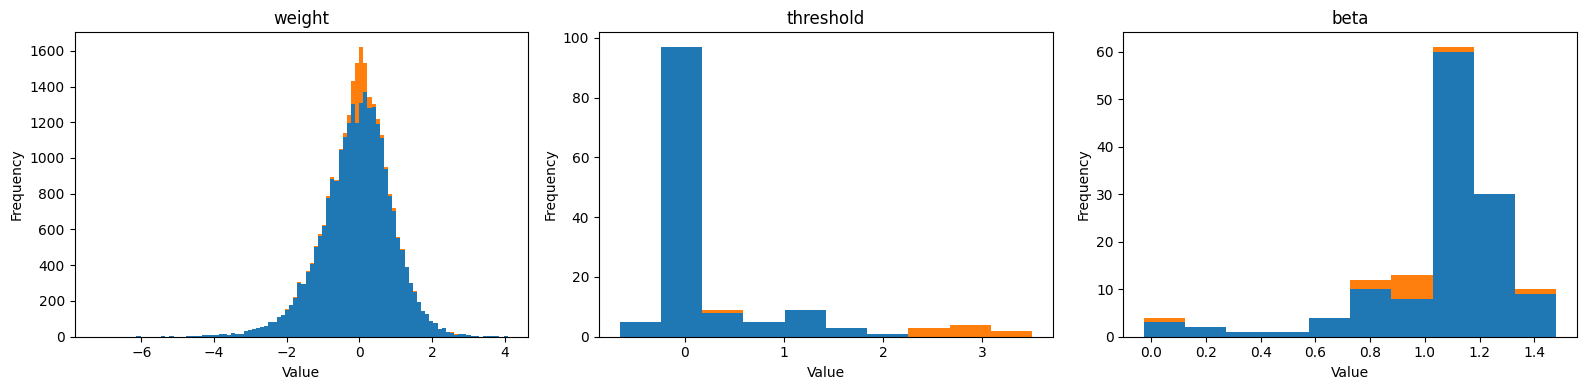

In [106]:
network.plot_parameter_distribution(scnn_net)

### Evaluate the Network on the Test Set

In [107]:
acc = network.eval_accuracy(device, scnn_net, testloader)
print("The average accuracy across the testloader is:", acc/len(testloader)*100)

Test progress:


IntProgress(value=0, max=73)

The average accuracy across the testloader is: 83.33537181996087


## Save the model

In [108]:
torch.save(scnn_net.state_dict(), "models/"+network_name+".pth")

# Evaluate the fixedpoint Network on the Test Set

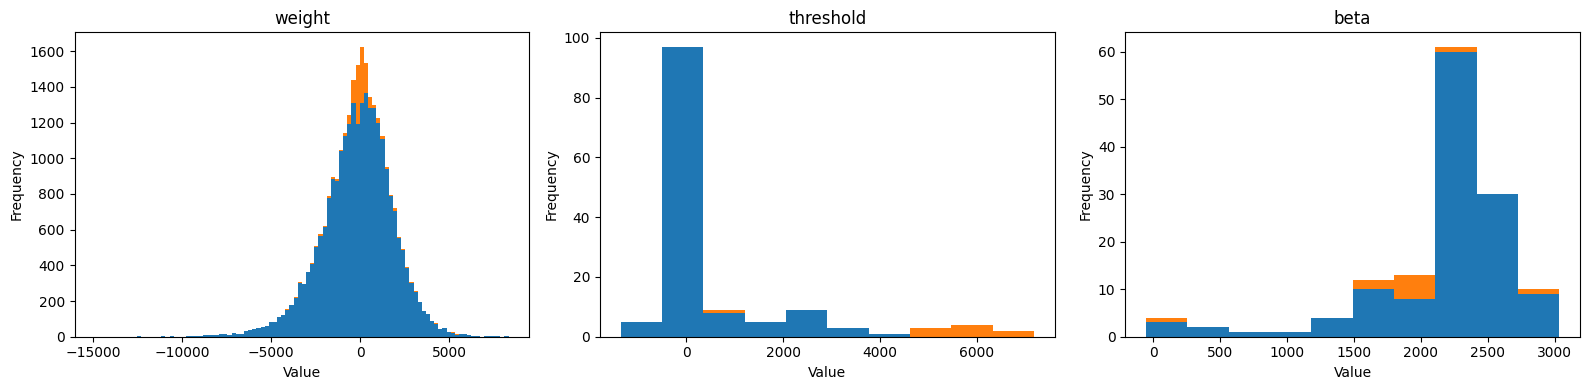

Test progress:


IntProgress(value=0, max=73)

	The average accuracy across the testloader is: 31.98


In [120]:
import neurons.quantization_utils
reload(neurons.quantization_utils)
from neurons.quantization_utils import copy_and_quantize_to_fixed_point

reload(network)

# Build the fixed point network
parameters_bit = 16
fractional_bits = 10

can_be_scaled = (neuron_type == "linear_LIF" or neuron_type == "IF")

scnn_net_fp = network.build_fixedpoint_network(device, neuron_type, input_size, hidden_size, output_size, fractional_bits)
copy_and_quantize_to_fixed_point(scnn_net, scnn_net_fp, parameters_bit, fractional_bits, scale=can_be_scaled)

if parameters_bit < 12:
    network.plot_int_parameter_distribution(scnn_net_fp)
else:
    network.plot_parameter_distribution(scnn_net_fp)

acc = network.eval_accuracy(device, scnn_net_fp, testloader)
print(f"\tThe average accuracy across the testloader is: {acc/len(testloader)*100:.2f}")

# Evaluate the minifloat Network on the Test Set

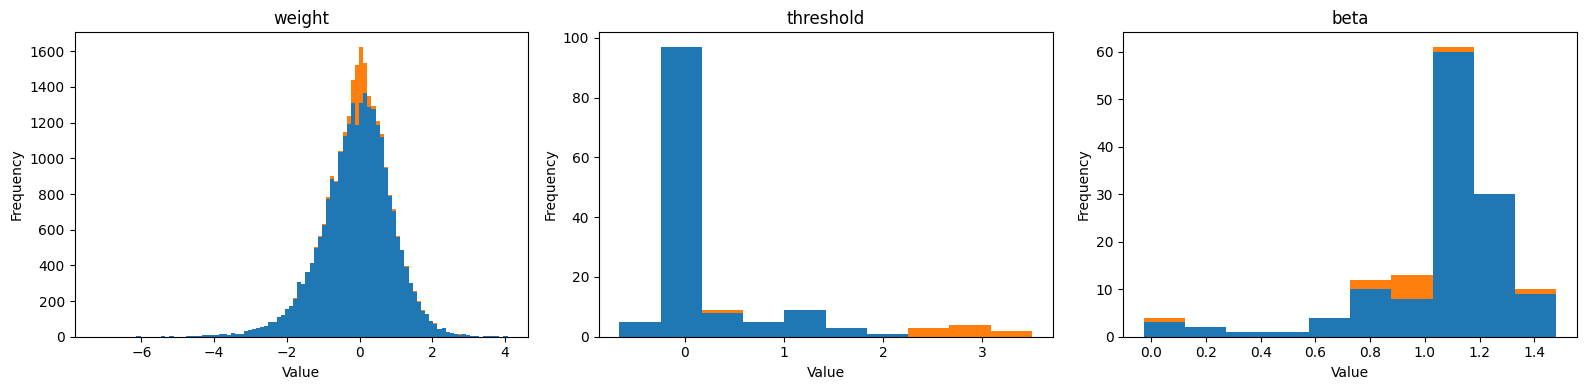

Test progress:


IntProgress(value=0, max=73)

The average accuracy across the testloader is: 46.75880626223092


In [112]:
# Build the minifloat network
import neurons.quantization_utils
reload(neurons.quantization_utils)
from neurons.quantization_utils import copy_and_quantize_to_minifloat

# 1 bit for the sign
exponent_bits = 5
mantissa_bits = 10

scnn_net_minifloat = network.build_minifloat_network(device, neuron_type, input_size, hidden_size, output_size, exponent_bits, mantissa_bits)        

copy_and_quantize_to_minifloat(scnn_net, scnn_net_minifloat, exponent_bits, mantissa_bits)

network.plot_parameter_distribution(scnn_net_minifloat)

acc = network.eval_accuracy(device, scnn_net_minifloat, testloader)
print("The average accuracy across the testloader is:", acc/len(testloader)*100)